# VGG16 Feature Extraction
### Justin Ledford

Sources: 

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

## Data and preprocessing
- Resize to 150x150
- Scale all RGB values from 0-255 to 0-1.

Using TensorFlow backend.


Found 1000 images belonging to 2 classes.


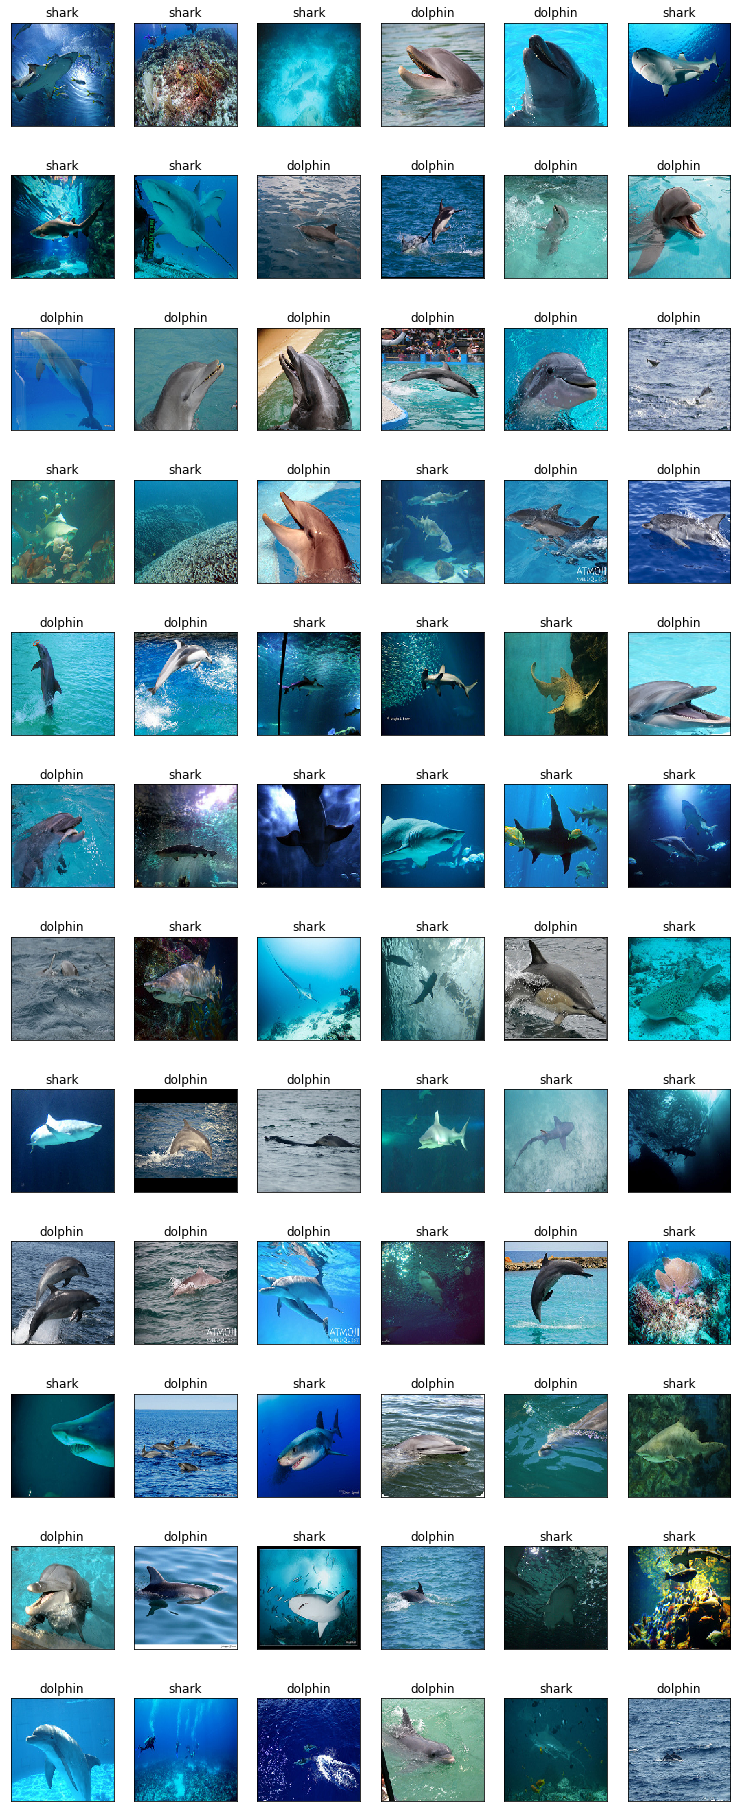

In [1]:
%matplotlib inline

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

test_dir = '../data/test'
test_datagen = ImageDataGenerator(rescale=1./255)
plot_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary')

num_images = 72
batch_size = 20
images = []
titles = []
i = 1
for inputs, labels in plot_generator:
    i += 1
    images.append(np.reshape(inputs, (150, 150, 3)))
    # Some predictions for class 0 can have underflow error
    # so check if == 1
    titles.append('shark' if labels[0] == 1 else 'dolphin')
   
    if i > num_images:
        break
        
        
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(images, titles, n_row=12, n_col=6)

# Feature Extraction
- Run all training and validation images through VGG16 with the classifier removed
  to extract the features

In [1]:
%%time

from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.applications import VGG16
from keras import optimizers
import pandas as pd

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = '../models/bottleneck_fc_model.h5'
train_data_dir = '../data/train'
validation_data_dir = '../data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16


#
# Save bottleneck features from VGG
#

# build the VGG16 network, leaving off the top classifier layer
# so we just get the features as output
print('Building VGG16...')
input_tensor = Input(shape=(150, 150, 3))
base_model = VGG16(weights='imagenet', include_top=False,
        input_tensor=input_tensor)

datagen = ImageDataGenerator(rescale=1/255)
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None, # class mode set to None here, because images are loaded in order, 
                     # so we know the first 1000 are dolphins, next 1000 are sharks
    shuffle=False)

print('Saving bottleneck features (train)...')
bottleneck_features_train = base_model.predict_generator(
    generator, nb_train_samples // batch_size)
np.save('../features/bottleneck_features_train.npy', bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

print('Saving bottleneck features (validation)...')
bottleneck_features_validation = base_model.predict_generator(
    generator, nb_validation_samples // batch_size)

np.save('../features/bottleneck_features_validation.npy',
        bottleneck_features_validation)



Using TensorFlow backend.


Building VGG16...
Found 2000 images belonging to 2 classes.
Saving bottleneck features (train)...
Found 800 images belonging to 2 classes.
Saving bottleneck features (validation)...
CPU times: user 32.3 s, sys: 7.85 s, total: 40.2 s
Wall time: 1min


# Train a classifier layer with extracted features

In [2]:
%%time

epochs = 30
batch_size = 20

#
# Train top model
#

train_data = np.load('../features/bottleneck_features_train.npy')
train_labels = np.array(
    [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load('../features/bottleneck_features_validation.npy')
validation_labels = np.array(
    [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))


print('Building top model...')
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

top_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

print('Training top model...')
history = top_model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              verbose=1)
top_model.save_weights(top_model_weights_path)




Building top model...
Training top model...
Train on 2000 samples, validate on 800 samples
Epoch 1/30
2000/2000 [==============================] - 1s - loss: 0.5957 - acc: 0.8430 - val_loss: 0.4585 - val_acc: 0.8500
Epoch 2/30
2000/2000 [==============================] - 0s - loss: 0.2192 - acc: 0.9200 - val_loss: 0.1686 - val_acc: 0.9325
Epoch 3/30
2000/2000 [==============================] - 0s - loss: 0.1517 - acc: 0.9455 - val_loss: 0.5242 - val_acc: 0.8813
Epoch 4/30
2000/2000 [==============================] - 0s - loss: 0.1637 - acc: 0.9420 - val_loss: 0.1936 - val_acc: 0.9225
Epoch 5/30
2000/2000 [==============================] - 0s - loss: 0.1392 - acc: 0.9570 - val_loss: 0.1879 - val_acc: 0.9425
Epoch 6/30
2000/2000 [==============================] - 0s - loss: 0.1154 - acc: 0.9595 - val_loss: 0.2915 - val_acc: 0.9250
Epoch 7/30
2000/2000 [==============================] - 0s - loss: 0.0952 - acc: 0.9655 - val_loss: 0.1963 - val_acc: 0.9450
Epoch 8/30
2000/2000 [============

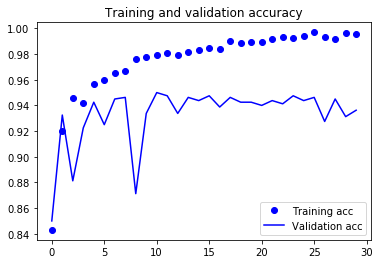

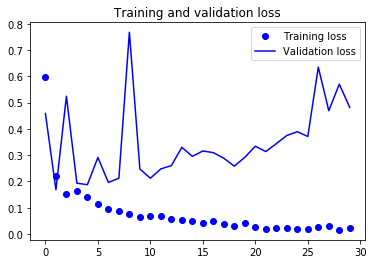

In [3]:
# Plot training and validation accuracy

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [4]:
%%time

epochs = 5
batch_size = 16

#
# Fine tune top convulational block
#

print('Building combined model...')
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs=base_model.input,
              outputs=top_model(base_model.output))

# Freeze all blocks up to block5 (the block we are fine tuning)
#set_trainable = False
#for layer in base_model.layers:
#    if layer.name == 'block5_conv1':
#        set_trainable = True
#    if set_trainable:
#        layer.trainable = True
#    else:
#        layer.trainable = False
for layer in model.layers[:25]:
    layer.trainable = False
    
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


# fine-tune the model
print('Training combined model...')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=1)

#pd.DataFrame(history.history).to_csv('../logs/fine-tune-%s.csv' % SLURM_JOBID)

Building combined model...
Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Training combined model...
Epoch 1/5
7/7 [==============================] - 2s - loss: 0.3106 - acc: 0.9643 - val_loss: 0.4815 - val_acc: 0.9363
Epoch 2/5
7/7 [==============================] - 2s - loss: 0.2140 - acc: 0.9643 - val_loss: 0.4937 - val_acc: 0.9363
Epoch 3/5
7/7 [==============================] - 2s - loss: 0.1153 - acc: 0.9821 - val_loss: 0.4536 - val_acc: 0.9363
Epoch 4/5
7/7 [==============================] - 2s - loss: 0.3128 - acc: 0.9643 - val_loss: 0.5408 - val_acc: 0.9325
Epoch 5/5
7/7 [==============================] - 2s - loss: 0.6850 - acc: 0.9196 - val_loss: 0.4838 - val_acc: 0.9287
CPU times: user 13.7 s, sys: 1.11 s, total: 14.9 s
Wall time: 12.1 s
